In [9]:
import glob

import pymaster as nmt

import healpy

import numpy as np

import pyccl as ccl

%matplotlib inline
import matplotlib.pyplot as plt

from simple_bootstrap.bootstrap import bootstrap_var, bootstrap

import sys
sys.path.append("../tools/")
from misc_utils import read_partial_map

PI = np.pi

In [2]:
Z_CUTS = [(0.1, 0.3),
          (0.3, 0.5),
          (0.5, 0.7),
          (0.7, 0.9),
          (0.9, 1.2),
         ]

BIN_OPERATOR = np.loadtxt("../data/xcorr/bin_operator_log_n_bin_12_ell_51-2952.txt")
BIN_OPERATOR_SQUARED = np.loadtxt("../data/xcorr/bin_operator_log_n_bin_12_ell_51-2952_squared_weights.txt")

n_ell_bin, n_ell = BIN_OPERATOR.shape

In [3]:
NMT_WORKSPACE_PATH = "/disk09/ttroester/project_triad/namaster_workspaces/"

In [5]:
# All KiDS
# KiDS1000_stats = [{"n_eff": 0.62, "sigma_e" : 0.27},
#                   {"n_eff": 1.18, "sigma_e" : 0.26},
#                   {"n_eff": 1.85, "sigma_e" : 0.27},
#                   {"n_eff": 1.26, "sigma_e" : 0.25},
#                   {"n_eff": 1.31, "sigma_e" : 0.27},]

# KiDS-N
# KiDS1000_stats = [{"n_eff": 0.62, "sigma_e" : 0.27},
#                   {"n_eff": 1.20, "sigma_e" : 0.26},
#                   {"n_eff": 1.82, "sigma_e" : 0.27},
#                   {"n_eff": 1.19, "sigma_e" : 0.25},
#                   {"n_eff": 1.17, "sigma_e" : 0.27},]

# KiDS-N map-based
KiDS1000_stats = [{"n_eff": 0.242, "sigma_e" : 0.157},
                  {"n_eff": 0.224, "sigma_e" : 0.114},
                  {"n_eff": 0.243, "sigma_e" : 0.105},
                  {"n_eff": 0.226, "sigma_e" : 0.114},
                  {"n_eff": 0.223, "sigma_e" : 0.123},]

ell = np.arange(3*2048)

Cl_gy_TE = 0*ell
Cl_gy_TB = 0*ell

Cl_gg_EE = []
for bin_idx in [0, 1, 2, 3, 4]:
    Cl_gg_EE += [np.ones_like(ell)*KiDS1000_stats[bin_idx]["sigma_e"]**2/(KiDS1000_stats[bin_idx]["n_eff"]*60**2/(1/180*PI)**2)]

Cl_gg_EB = 0*Cl_gg_EE[0]
Cl_gg_BB = 0*Cl_gg_EE[0]

# Planck milca half-difference x random shear

In [5]:
random_shear_data = np.load("../../project-triad-obsolete/results/measurements/shear_KiDS1000_y/shear_KiDS1000_y_random_shear.npz")

ell = np.arange(BIN_OPERATOR.shape[1])

y_map = "milca_half_difference"
d = []
for z_cut in Z_CUTS:
    tag = f"z{z_cut[0]:.1f}-{z_cut[1]:.1f}-{y_map}"
    binned = np.einsum("ij,kjl->lik", BIN_OPERATOR, random_shear_data[tag])
    d.append(binned)
    
d = np.concatenate(d, axis=1)
cov_random_shear = np.cov(d[0])

In [55]:
ell_Planck, Cl_milca_half_difference_yy = np.loadtxt("../../project-triad-obsolete/results/measurements/y_y/milca-half-difference-ellmax_4000/spice.cl", unpack=True)

Cl_yy_TT = np.concatenate((Cl_milca_half_difference_yy, np.zeros(3*2048-Cl_milca_half_difference_yy.size)))



In [13]:
nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
nmt_cov_workspace.read_from("/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_cov_workspace_foreground_shear_4_foreground_shear_4.fits")

nmt_workspace_y_shear_A = nmt.NmtWorkspace()
nmt_workspace_y_shear_A.read_from("/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_4.fits")
nmt_workspace_y_shear_B = nmt.NmtWorkspace()
nmt_workspace_y_shear_B.read_from("/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_4.fits")

In [56]:
cov_gaussian_TE_TE = []

for bin_idx in [0, 1, 2, 3, 4]:
    nmt_workspace_y_shear_A = nmt.NmtWorkspace()
    nmt_workspace_y_shear_A.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_workspace_y_shear_B = nmt.NmtWorkspace()
    nmt_workspace_y_shear_B.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
    nmt_cov_workspace.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_milca_namaster/pymaster_cov_workspace_foreground_shear_{bin_idx}_foreground_shear_{bin_idx}.fits")

    cov_gaussian = nmt.covariance.gaussian_covariance(nmt_cov_workspace, 
                                                    spin_a1=0, spin_a2=2,
                                                    spin_b1=0, spin_b2=2,
                                                    cla1b1=[Cl_yy_TT],
                                                    cla1b2=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b1=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b2=[Cl_gg_EE[bin_idx], Cl_gg_EB, Cl_gg_EB, Cl_gg_BB],
                                                    wa=nmt_workspace_y_shear_A,
                                                    wb=nmt_workspace_y_shear_B).reshape([n_ell_bin, 2,
                                                                                         n_ell_bin, 2])
    cov_gaussian_TE_TE += [cov_gaussian[:, 0, :, 0]]

In [76]:
cov_gaussian_TE_TE_naive = []

ell = np.arange(Cl_yy_TT.size)

A_eff = 636.8005428
A_eff = 500.0
fsky_eff = A_eff/(4*PI*(180/PI)**2)

for bin_idx in [0, 1, 2, 3, 4]:
    cov = 1/(fsky_eff*(2*ell+1))*(Cl_yy_TT*Cl_gg_EE[bin_idx])
    
    cov_gaussian_TE_TE_naive += [BIN_OPERATOR_SQUARED @ cov[:n_ell]]

Text(0.5, 0.98, 'Noise-only covariance')

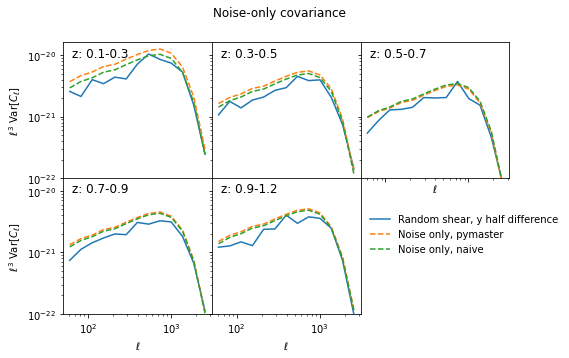

In [77]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for i, z_cut in enumerate(Z_CUTS):
    ell_eff = BIN_OPERATOR @ np.arange(n_ell)
    u = ell_eff**3
    cov = cov_random_shear
    var = np.diag(cov)[n_ell_bin*i:n_ell_bin*(i+1)]

    ax.flatten()[i].loglog(ell_eff, u*var, ls="-", label=f"Random shear, y half difference")

    var = np.diag(cov_gaussian_TE_TE[i])
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"Noise only, pymaster")

    var = cov_gaussian_TE_TE_naive[i]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"Noise only, naive")
    
    
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)

[p[0].set_ylabel(r"$\ell^3\ {\rm Var}[C_\ell]$") for p in ax]
ax.flatten()[-1].axis("off")
ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

ax[0,0].set_ylim(bottom=1e-22)

fig.suptitle("Noise-only covariance")

# ACT BN x random shear

In [5]:

random_shear_data_TE = []
random_shear_data_TB = []

for filename in glob.glob("../results/measurements/shear_KiDS1000_random_shear_y_ACT_BN_namaster/run_*/Cl_decoupled.txt"):
    d_TE = np.concatenate(np.loadtxt(filename, unpack=True, usecols=[1, 3, 5, 7, 9]))
    d_TB = np.concatenate(np.loadtxt(filename, unpack=True, usecols=[2, 4, 6, 8, 10]))
    random_shear_data_TE.append(d_TE)
    random_shear_data_TB.append(d_TB)

cov_random_shear_TE = np.cov(np.array(random_shear_data_TE).T, ddof=1)
cov_random_shear_TB = np.cov(np.array(random_shear_data_TB).T, ddof=1)
cov_random_shear_combined = np.cov(np.array(random_shear_data_TE+random_shear_data_TB).T, ddof=1)

In [6]:
ell_ACT_coupled, Cl_ACT_BN_yy_coupled = np.loadtxt("../results/measurements/y_y_ACT_BN_namaster/Cl_TT_coupled.txt", unpack=True)
ell_ACT_decoupled, Cl_ACT_BN_yy_decoupled = np.loadtxt("../results/measurements/y_y_ACT_BN_namaster/Cl_TT_decoupled.txt", unpack=True)

nmt_bins = nmt.NmtBin.from_nside_linear(
                        nside=2048,
                        nlb=10)
Cl_ACT_BN_yy = nmt_bins.unbin_cell(Cl_ACT_BN_yy_decoupled)

Cl_yy_TT = np.concatenate((Cl_ACT_BN_yy, np.zeros(3*2048-Cl_ACT_BN_yy.size)))

np.savetxt("../results/measurements/y_y_ACT_BN_namaster/Cl_TT_decoupled_unbinned.txt",
           np.vstack((np.arange(Cl_yy_TT.size), Cl_yy_TT)).T)


In [37]:
cov_gaussian_TE_TE = []
cov_gaussian_TB_TB = []

for bin_idx in [0, 1, 2, 3, 4]:
    nmt_workspace_y_shear_A = nmt.NmtWorkspace()
    nmt_workspace_y_shear_A.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_ACT_BN_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_workspace_y_shear_B = nmt.NmtWorkspace()
    nmt_workspace_y_shear_B.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_ACT_BN_namaster/pymaster_workspace_foreground_shear_{bin_idx}.fits")

    nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
    nmt_cov_workspace.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_y_ACT_BN_namaster/pymaster_cov_workspace_foreground_shear_{bin_idx}_foreground_shear_{bin_idx}.fits")

    cov_gaussian = nmt.covariance.gaussian_covariance(nmt_cov_workspace, 
                                                    spin_a1=0, spin_a2=2,
                                                    spin_b1=0, spin_b2=2,
                                                    cla1b1=[Cl_yy_TT],
                                                    cla1b2=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b1=[Cl_gy_TE, Cl_gy_TB],
                                                    cla2b2=[Cl_gg_EE[bin_idx], Cl_gg_EB, Cl_gg_EB, Cl_gg_BB],
                                                    wa=nmt_workspace_y_shear_A,
                                                    wb=nmt_workspace_y_shear_B).reshape([n_ell_bin, 2,
                                                                                         n_ell_bin, 2])
    cov_gaussian_TE_TE += [cov_gaussian[:, 0, :, 0]]
    cov_gaussian_TB_TB += [cov_gaussian[:, 1, :, 1]]

## Compute statistics from maps

In [21]:
y_mask = healpy.read_map("../data/y_maps/ACT/BN_mask.fits", verbose=False)
y_mask[y_mask == healpy.UNSEEN] = 0

A_ACT_BN = y_mask.sum()*healpy.nside2pixarea(2048, degrees=True)

A_KiDS = {}
A_eff_KiDS = {}

A_ACT_BN_KiDS = {}

sum_w_map = {}
sum_w_sq_map = {}
sum_w_sq_e1_sq_map = {}
sum_w_sq_e2_sq_map = {}
sigma_e_map = {}
n_eff_map = {}

for z_cut in Z_CUTS + [(0.1, 1.2)]:
    shear_mask = healpy.read_map(f"../data/shear_maps_KiDS1000_cel_N/z{z_cut[0]}-{z_cut[1]}/doublet_mask.fits", verbose=False)
    shear_mask[shear_mask == healpy.UNSEEN] = 0

    shear_weight = healpy.read_map(f"../data/shear_maps_KiDS1000_cel_N/z{z_cut[0]}-{z_cut[1]}/doublet_weight.fits", verbose=False)
    shear_weight[shear_weight == healpy.UNSEEN] = 0

    e1, e2 = read_partial_map(f"../data/shear_maps_KiDS1000_cel_N/z{z_cut[0]}-{z_cut[1]}/triplet.fits",
                                fields=[2, 3], fill_value=0,
                                scale=[1, 1])

    sum_w_map[z_cut] = np.sum(shear_weight)
    sum_w_sq_map[z_cut] = np.sum(shear_weight**2)
    sum_w_sq_e1_sq_map[z_cut] = np.sum(shear_weight**2 * e1**2)
    sum_w_sq_e2_sq_map[z_cut] = np.sum(shear_weight**2 * e2**2)

    shear_weight *= shear_mask.sum()/shear_weight[shear_weight > 0].sum()

    A_KiDS[z_cut] = shear_mask.sum()*healpy.nside2pixarea(2048, degrees=True)
    A_eff_KiDS[z_cut] = shear_weight.sum()*healpy.nside2pixarea(2048, degrees=True)
    A_ACT_BN_KiDS[z_cut] = (shear_weight*y_mask).sum()*healpy.nside2pixarea(2048, degrees=True)

    sigma_e_map[z_cut] = np.sqrt(0.5*(sum_w_sq_e1_sq_map[z_cut] + sum_w_sq_e2_sq_map[z_cut])/sum_w_sq_map[z_cut])
    n_eff_map[z_cut] = sum_w_map[z_cut]**2/sum_w_sq_map[z_cut]/(A_KiDS[z_cut]*60**2)

    print(f"{z_cut}: A_KiDS = {A_KiDS[z_cut]:.1f} deg^2, A_ACT_BN_KiDS = {A_ACT_BN_KiDS[z_cut]:.1f} deg^2")
    print(f"          sigma_e = {sigma_e_map[z_cut]:.2f}, n_eff = {n_eff_map[z_cut]:.3f} arcmin^-2")



/home/ttroester/Codes/miniconda/envs/kcap_env_re/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
(0.1, 0.3): A_KiDS = 325.1 deg^2, A_ACT_BN_KiDS = 254.0 deg^2
    sigma_e = 0.16, n_eff = 0.242 arcmin^-2
(0.3, 0.5): A_KiDS = 390.6 deg^2, A_ACT_BN_KiDS = 302.3 deg^2
    sigma_e = 0.11, n_eff = 0.224 arcmin^-2
(0.5, 0.7): A_KiDS = 415.8 deg^2, A_ACT_BN_KiDS = 323.0 deg^2
    sigma_e = 0.10, n_eff = 0.243 arcmin^-2
(0.7, 0.9): A_KiDS = 400.4 deg^2, A_ACT_BN_KiDS = 316.2 deg^2
    sigma_e = 0.11, n_eff = 0.226 arcmin^-2
(0.9, 1.2): A_KiDS = 401.5 deg^2, A_ACT_BN_KiDS = 315.4 deg^2
    sigma_e = 0.12, n_eff = 0.223 arcmin^-2
(0.1, 1.2): A_KiDS = 431.4 deg^2, A_ACT_BN_KiDS = 336.7 deg^2
    sigma_e =

In [29]:
[print(f"{z}: {n:.3f}") for z, n in n_eff_map.items()]
print()
[print(f"{n:.3f}") for z, n in sigma_e_map.items()]

(0.1, 0.3): 0.242
(0.3, 0.5): 0.224
(0.5, 0.7): 0.243
(0.7, 0.9): 0.226
(0.9, 1.2): 0.223
(0.1, 1.2): 0.276

0.157
0.114
0.105
0.114
0.123
0.062


[None, None, None, None, None, None]

In [32]:
cov_gaussian_TE_TE_naive = []
cov_gaussian_TE_TE_naive_fixed_area = []

ell = np.arange(Cl_yy_TT.size)

for bin_idx in [0, 1, 2, 3, 4]:
    A_eff = list(A_ACT_BN_KiDS.values())[bin_idx]
    fsky_eff = A_eff/(4*PI*(180/PI)**2)
    cov = 1/(fsky_eff*(2*ell+1))*(Cl_yy_TT*Cl_gg_EE[bin_idx])
    cov_gaussian_TE_TE_naive += [BIN_OPERATOR_SQUARED @ cov[:n_ell]]

    A_eff = 291
    fsky_eff = A_eff/(4*PI*(180/PI)**2)
    cov = 1/(fsky_eff*(2*ell+1))*(Cl_yy_TT*Cl_gg_EE[bin_idx])
    cov_gaussian_TE_TE_naive_fixed_area += [BIN_OPERATOR_SQUARED @ cov[:n_ell]]

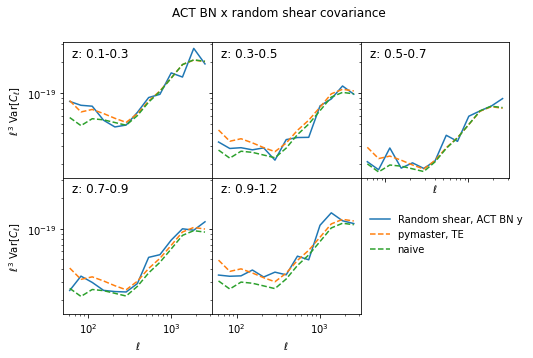

In [41]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0)

for i, z_cut in enumerate(Z_CUTS):
    ell_eff = BIN_OPERATOR @ np.arange(n_ell)
    u = ell_eff**3
    
    cov = cov_random_shear_TE
    var = np.diag(cov)[n_ell_bin*i:n_ell_bin*(i+1)]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="-", label=f"Random shear, ACT BN y")

    # cov = cov_random_shear_TB
    # var = np.diag(cov)[n_ell_bin*i:n_ell_bin*(i+1)]
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="-", label=f"Random shear, ACT BN y, TB")

    var = np.diag(cov_gaussian_TE_TE[i])/np.sqrt(2)
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"pymaster, TE")

    # var = np.diag(cov_gaussian_TE_TE[i])
    # var = var * A_ACT_BN_KiDS[z_cut]/A_ACT_BN_KiDS[(0.1, 1.2)]
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"pymaster, rescaled, TE")

    # var = np.diag(cov_gaussian_TB_TB[i])
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"pymaster, TB")

    var = cov_gaussian_TE_TE_naive[i]
    ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"naive")

    # var = cov_gaussian_TE_TE_naive_fixed_area[i]
    # ax.flatten()[i].loglog(ell_eff, u*var, ls="--", label=f"naive, A = 291 sq. deg")
    
    
    ax.flatten()[i].set_xlabel(r"$\ell$")
    ax.flatten()[i].set_title(f"z: {z_cut[0]}-{z_cut[1]}", x=0.25, y=0.85)

[p[0].set_ylabel(r"$\ell^3\ {\rm Var}[C_\ell]$") for p in ax]
ax.flatten()[-1].axis("off")
ax.flatten()[-2].legend(frameon=False, loc="upper left", bbox_to_anchor=(1,0.8))

# ax[0,0].set_ylim(bottom=1e-22)

fig.suptitle("ACT BN x random shear covariance")
fig.savefig("plots/ACT_BN_noise_cov.png", dpi=300)

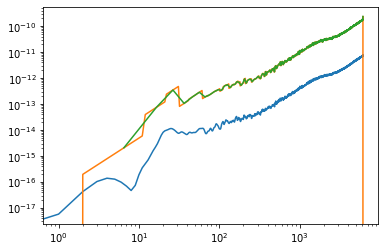

In [11]:
u = ell_ACT_coupled**2/(2*PI)
plt.loglog(ell_ACT_coupled, u*Cl_ACT_BN_yy_coupled)
plt.loglog(ell_ACT_coupled, u*Cl_ACT_BN_yy)

u = ell_ACT_decoupled**2/(2*PI)
plt.loglog(ell_ACT_decoupled, u*Cl_ACT_BN_yy_decoupled)

In [52]:
def prob_empty_pixel(n_eff, per_arcmin=True):
    if per_arcmin:
        n_per_pixel = n_eff*60**2*healpy.nside2pixarea(2048, degrees=True)
    else:
        n_per_pixel = n_eff
    P_0 = np.exp(-n_per_pixel)
    return P_0

[(1-prob_empty_pixel(n))**2 for z, n in n_eff.items()]

[0.7030722676654956,
 0.9431627508988449,
 0.990759946473253,
 0.9416274619248236,
 0.9379349663676517,
 0.9999999522214954]

# Shear - shear

In [4]:
SHEAR_COV_BINS = [((0, 0), (0, 0)),
                  ((1, 0), (1, 0)),
                  ((1, 1), (1, 1)),
                  #((0, 0), (1, 0)),
                  #((0, 0), (1, 1))
                  ]

In [5]:
# KiDS catalog-based
n_eff = np.loadtxt("../data/shear_stats/n_eff_All_catalog.txt")[[0,4]]
sigma_e = np.loadtxt("../data/shear_stats/sigma_e_All_catalog.txt")[[0,4]]
A_KiDS = [np.loadtxt("../data/shear_stats/area_All_catalog.txt")]*2
sum_w, sum_w_sq, sum_w_sq_e1_sq, sum_w_sq_e2_sq = np.loadtxt("../data/shear_stats/raw_stats_All_catalog.txt")[[0,4]].T

sum_w_sq_e_sq = (sum_w_sq_e1_sq+sum_w_sq_e2_sq)/2

sum_w_sq_map = np.loadtxt("../data/shear_stats/raw_stats_All_gal_map.txt", usecols=[1])[[0,4]]

ell = np.arange(3*2048)

Cl_N = {}
Cl_N_cov = {}
Cl_0 = np.zeros_like(ell)
Cl_1 = np.ones_like(ell)

pixel_area = healpy.nside2pixarea(2048)
n_pix = healpy.nside2npix(2048)

for (idx_a1, idx_a2) in [(0, 0), (1, 0), (0, 1), (1, 1)]:
    if (idx_a1, idx_a2) not in Cl_N:
        if idx_a1 == idx_a2:
            N_bias = pixel_area * sum_w_sq_e_sq[idx_a1]/n_pix
            N_cov = pixel_area * (sum_w_sq_e_sq/sum_w_sq_map)[idx_a1]
            
            Cl_N[(idx_a1, idx_a2)] = np.ones_like(ell) * N_bias
            Cl_N_cov[(idx_a1, idx_a2)] = np.ones_like(ell) * N_cov
        else:
            Cl_N[(idx_a1, idx_a2)] = Cl_0
            Cl_N_cov[(idx_a1, idx_a2)] = Cl_0


In [9]:
true_random_shear_EE = {(0,0): np.load("../results/measurements/shear_KiDS1000_true_randoms_namaster/run_0/Cl_decoupled_z0.1-0.3_gal.npz")["EE"][:],
                        (1,0): np.load("../results/measurements/shear_KiDS1000_true_randoms_namaster/run_0/Cl_decoupled_z0.1-0.3_z0.9-1.2_gal.npz")["EE"][:],
                        (1,1): np.load("../results/measurements/shear_KiDS1000_true_randoms_namaster/run_0/Cl_decoupled_z0.9-1.2_gal.npz")["EE"][:]}

In [10]:
random_shear_data_EE = []
random_shear_data_BB = []

for filename_EE, filename_BB in zip(glob.glob("../results/measurements/shear_KiDS1000_auto_randoms_namaster/run_*/Cl_EE_decoupled.txt"),
                                    glob.glob("../results/measurements/shear_KiDS1000_auto_randoms_namaster/run_*/Cl_BB_decoupled.txt")):
    d_EE = np.concatenate(np.loadtxt(filename_EE, unpack=True, usecols=[1, 2, 3]))
    d_BB = np.concatenate(np.loadtxt(filename_BB, unpack=True, usecols=[1, 2, 3]))
    random_shear_data_EE.append(d_EE)
    random_shear_data_BB.append(d_BB)

cov_random_shear_EE = np.cov(np.array(random_shear_data_EE).T, ddof=1)
cov_random_shear_BB = np.cov(np.array(random_shear_data_BB).T, ddof=1)
cov_random_shear_combined = np.cov(np.array(random_shear_data_EE+random_shear_data_BB).T, ddof=1)

mean_random_shear_EE = np.mean(np.array(random_shear_data_EE), axis=0)
mean_random_shear_BB = np.mean(np.array(random_shear_data_BB), axis=0)


randoms_cov_slice = {(0, 0): slice(0, n_ell_bin),
                     (1, 0): slice(n_ell_bin, 2*n_ell_bin),
                     (1, 1): slice(2*n_ell_bin, 3*n_ell_bin),}

In [6]:
nmt_workspace = {}
nmt_workspace[(0,0)] = nmt.NmtWorkspace()
nmt_workspace[(0,0)].read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/pymaster_workspace_shear_0_shear_0.fits")
nmt_workspace[(1,1)] = nmt.NmtWorkspace()
nmt_workspace[(1,1)].read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/pymaster_workspace_shear_1_shear_1.fits")


NameError: name 'mean_random_shear_EE' is not defined

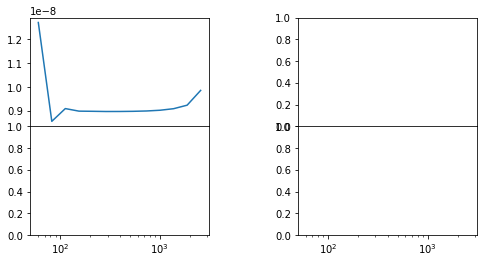

In [12]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(8,4))
fig.subplots_adjust(hspace=0, wspace=0.5)

ell_eff = BIN_OPERATOR @ np.arange(n_ell)

for i, idx in enumerate([(0,0), (1,1)]):
    u = 1#ell**2
    Cl_theory = nmt_workspace[idx].decouple_cell([Cl_N[idx], Cl_0, Cl_0, Cl_N[idx]])[0]
    ax[0, i].semilogx(ell_eff, u*(Cl_theory), label="Analytic noise bias (Eq. 2.24)")

    u = 1#ell_eff**2
    Cl = mean_random_shear_EE[randoms_cov_slice[idx]]
    std = np.sqrt(np.diag(cov_random_shear_EE[randoms_cov_slice[idx], randoms_cov_slice[idx]])/len(random_shear_data_EE))
    ax[0, i].errorbar(ell_eff, u*Cl, u*std, ls="none", marker=".", label="Map randoms")

    ax[1, i].axhline(0, c="k", lw=1)
    ax[1, i].errorbar(ell_eff, Cl/Cl_theory-1, std/Cl_theory, ls="none", marker=".", c="C1")

    
    u = 1#ell_eff**2
    Cl = true_random_shear_EE[idx].mean(axis=0) 
    std = np.sqrt(np.var(true_random_shear_EE[idx], axis=0, ddof=1)/true_random_shear_EE[idx].shape[0])
    ax[0, i].errorbar(ell_eff*1.02, u*Cl, u*std, ls="none", marker=".", label="Galaxy randoms")

    ax[1, i].axhline(0, c="k", lw=1)
    ax[1, i].errorbar(ell_eff*1.02, Cl/Cl_theory-1, std/Cl_theory, ls="none", marker=".", c="C2")

    ax[0, i].set_xlim(50, 3000)
    ax[1, i].set_ylim(-0.02, 0.02)

    ax.flatten()[i].set_title(f"{idx}")


[a.set_xlabel(r"$\ell$") for a in ax[1]]
[a.set_ylabel(r"$C_\ell$") for a in ax[0]]
[a.set_ylabel(r"$\Delta C_\ell/C_\ell$") for a in ax[1]]

ax[0, 0].legend(frameon=False, fontsize="small")
fig.suptitle("Noise bias")
fig.savefig("plots/noise_bias.png", facecolor="w", dpi=300)


In [13]:
cov_gaussian_EE_EE = []
cov_gaussian_BB_BB = []


for (idx_a1, idx_a2), (idx_b1, idx_b2) in SHEAR_COV_BINS:
    print((idx_a1, idx_a2), (idx_b1, idx_b2))
    
    nmt_workspace_A = nmt.NmtWorkspace()
    nmt_workspace_A.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/pymaster_workspace_shear_{idx_a1}_shear_{idx_a2}.fits")

    nmt_workspace_B = nmt.NmtWorkspace()
    nmt_workspace_B.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/pymaster_workspace_shear_{idx_b1}_shear_{idx_b2}.fits")

    nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
    nmt_cov_workspace.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/"
                                f"pymaster_cov_workspace"
                                f"_shear_{idx_a1}_shear_{idx_a2}"
                                f"_shear_{idx_b1}_shear_{idx_b2}.fits")

    cov_gaussian = nmt.covariance.gaussian_covariance(nmt_cov_workspace, 
                                                    spin_a1=2, spin_a2=2,
                                                    spin_b1=2, spin_b2=2,
                                                    cla1b1=[Cl_N_cov[(idx_a1, idx_b1)], Cl_0,
                                                            Cl_0, Cl_N_cov[(idx_a1, idx_b1)]],
                                                    cla1b2=[Cl_N_cov[(idx_a1, idx_b2)], Cl_0,
                                                            Cl_0, Cl_N_cov[(idx_a1, idx_b2)]],
                                                    cla2b1=[Cl_N_cov[(idx_a2, idx_b1)], Cl_0,
                                                            Cl_0, Cl_N_cov[(idx_a2, idx_b1)]],
                                                    cla2b2=[Cl_N_cov[(idx_a2, idx_b2)], Cl_0,
                                                            Cl_0, Cl_N_cov[(idx_a2, idx_b2)]],
                                                    wa=nmt_workspace_A,
                                                    wb=nmt_workspace_B).reshape([n_ell_bin, 4,
                                                                                 n_ell_bin, 4])
    cov_gaussian_EE_EE += [cov_gaussian[:, 0, :, 0]]
    cov_gaussian_BB_BB += [cov_gaussian[:, 3, :, 3]]

(0, 0) (0, 0)
(1, 0) (1, 0)
(1, 1) (1, 1)


In [14]:
cov_gaussian_EE_EE_exact_noise = []

for (idx_a1, idx_a2), (idx_b1, idx_b2) in SHEAR_COV_BINS:
    print((idx_a1, idx_a2), (idx_b1, idx_b2))
    
    print("Loading Cl workspaces")
    nmt_workspace_A = nmt.NmtWorkspace()
    nmt_workspace_A.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/pymaster_workspace_shear_{idx_a1}_shear_{idx_a2}.fits")

    if (idx_a1, idx_a2) == (idx_b1, idx_b2):
        nmt_workspace_B = nmt_workspace_A
    else:
        nmt_workspace_B = nmt.NmtWorkspace()
        nmt_workspace_B.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/pymaster_workspace_shear_{idx_b1}_shear_{idx_b2}.fits")

    print("Loading covariance workspace")
    nmt_cov_workspace = nmt.NmtCovarianceWorkspace()
    nmt_cov_workspace.read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_auto_namaster/"
                                f"pymaster_cov_workspace"
                                f"_shear_noise_{idx_a1}_shear_noise_{idx_a2}"
                                f"_shear_noise_{idx_b1}_shear_noise_{idx_b2}.fits")

    print("Computing covariance")
    if idx_a1 == idx_b1 and idx_a2 == idx_b2:
        cov_gaussian = nmt.covariance.gaussian_covariance(nmt_cov_workspace, 
                                                        spin_a1=2, spin_a2=2,
                                                        spin_b1=2, spin_b2=2,
                                                        cla1b1=[Cl_1, Cl_0, Cl_0, Cl_1],
                                                        cla1b2=[Cl_0, Cl_0, Cl_0, Cl_0],
                                                        cla2b1=[Cl_0, Cl_0, Cl_0, Cl_0],
                                                        cla2b2=[Cl_1, Cl_0, Cl_0, Cl_1],
                                                        wa=nmt_workspace_A,
                                                        wb=nmt_workspace_B).reshape([n_ell_bin, 4,
                                                                                    n_ell_bin, 4])
    elif idx_a1 == idx_b2 and idx_a2 == idx_b1:
        cov_gaussian = nmt.covariance.gaussian_covariance(nmt_cov_workspace, 
                                                        spin_a1=2, spin_a2=2,
                                                        spin_b1=2, spin_b2=2,
                                                        cla1b1=[Cl_0, Cl_0, Cl_0, Cl_0],
                                                        cla1b2=[Cl_1, Cl_0, Cl_0, Cl_1],
                                                        cla2b1=[Cl_1, Cl_0, Cl_0, Cl_1],
                                                        cla2b2=[Cl_0, Cl_0, Cl_0, Cl_0],
                                                        wa=nmt_workspace_A,
                                                        wb=nmt_workspace_B).reshape([n_ell_bin, 4,
                                                                                    n_ell_bin, 4])

    cov_gaussian *= pixel_area**2
    if (idx_a1 == idx_a2) and (idx_b1 == idx_b2):
        cov_gaussian *= 2
    cov_gaussian_EE_EE_exact_noise += [cov_gaussian[:, 0, :, 0]]


(0, 0) (0, 0)
Loading Cl workspaces
Loading covariance workspace
Computing covariance
(1, 0) (1, 0)
Loading Cl workspaces
Loading covariance workspace
Computing covariance
(1, 1) (1, 1)
Loading Cl workspaces
Loading covariance workspace
Computing covariance


In [19]:
cov_gaussian_EE_EE_naive = []

for (idx_a1, idx_a2), (idx_b1, idx_b2) in SHEAR_COV_BINS:
    A_eff = (A_KiDS[idx_a1]*A_KiDS[idx_a2]*A_KiDS[idx_b1]*A_KiDS[idx_b2])**(1/4)
    fsky_eff = A_eff/(4*PI*(180/PI)**2)

    cov = 1/(fsky_eff*(2*ell+1))*(Cl_N[(idx_a1, idx_b1)]*Cl_N[(idx_a2, idx_b2)] + Cl_N[(idx_a1, idx_b2)]*Cl_N[(idx_a2, idx_b1)])

    cov_gaussian_EE_EE_naive += [BIN_OPERATOR_SQUARED @ cov[:n_ell]]


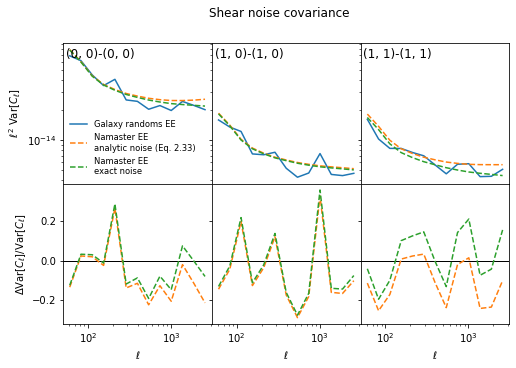

In [18]:
fig, ax = plt.subplots(2, 3, sharex=True, sharey="row", squeeze=False, figsize=(8, 5))
fig.subplots_adjust(hspace=0, wspace=0.0, bottom=0.1)

for i, ((idx_a1, idx_a2), (idx_b1, idx_b2)) in enumerate(SHEAR_COV_BINS):
    ell_eff = BIN_OPERATOR @ np.arange(n_ell)
    u = ell_eff**2
    
    ax[1, i].axhline(0, c="k", lw=1)

    cov = cov_random_shear_EE[randoms_cov_slice[(idx_a1, idx_a2)], randoms_cov_slice[(idx_b1, idx_b2)]]
    var_randoms = np.diag(cov)
    # ax[0, i].loglog(ell_eff, u*var_randoms, ls="-", label=f"Randoms EE")

    if (idx_a1, idx_a2) == (idx_b1, idx_b2):
        var_true_randoms = np.var(true_random_shear_EE[(idx_a1, idx_a2)], axis=0, ddof=1)
        ax[0, i].loglog(ell_eff, u*var_true_randoms, ls="-", label=f"Galaxy randoms EE")

    cov = cov_gaussian_EE_EE[i]
    var = np.diag(cov)
    ax[0, i].loglog(ell_eff, u*var, ls="--", c="C1", label=f"Namaster EE\nanalytic noise (Eq. 2.33)")
    # ax[1, i].semilogx(ell_eff, var_randoms/var-1, ls="--", c="C1")
    ax[1, i].semilogx(ell_eff, var_true_randoms/var-1, ls="--", c="C1")

    cov = cov_gaussian_EE_EE_exact_noise[i]
    var = np.diag(cov)
    ax[0, i].loglog(ell_eff, u*var, ls="--", c="C2", label=f"Namaster EE\nexact noise")
    # ax[1, i].semilogx(ell_eff, var_randoms/var-1, ls="--", c="C2")
    ax[1, i].semilogx(ell_eff, var_true_randoms/var-1, ls="--", c="C2")

    ax[1, i].set_xlabel(r"$\ell$")
    ax[0, i].set_title(f"{(idx_a1, idx_a2)}-{(idx_b1, idx_b2)}", x=0.25, y=0.85)

    ax[0, i].set_yscale("log")

ax[0, 0].set_ylabel(r"$\ell^2\ {\rm Var}[C_\ell]$")
ax[1, 0].set_ylabel(r"$\Delta{\rm Var}[C_\ell]/{\rm Var}[C_\ell]$")

ax[0, 0].legend(frameon=False, fontsize="small")

fig.suptitle("Shear noise covariance")
fig.savefig("plots/shear_noise_cov.png", facecolor="w", dpi=300)

# Simulate white noise

In [2]:
import tqdm

In [75]:
real_weights = healpy.read_map(f"../data/shear_maps_KiDS1000_cel/z0.1-0.3/doublet_weight.fits", verbose=False)
real_weights[real_weights == healpy.UNSEEN] = 0

real_weights_sq = healpy.read_map(f"../data/shear_maps_KiDS1000_cel/z0.1-0.3/w_sq.fits", verbose=False)
real_weights_sq[real_weights_sq == healpy.UNSEEN] = 0

n_gal = healpy.read_map(f"../data/shear_maps_KiDS1000_cel/z0.1-0.3/n_gal.fits", verbose=False)
n_gal[n_gal == healpy.UNSEEN] = 0


/home/ttroester/Codes/miniconda/envs/kcap_env_re/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


In [113]:

nmt_22_workspace = {}

EE_coupled_mean = {}
EE_coupled_err = {}
EE_decoupled_mean = {}
EE_decoupled_err = {}

mask_mean = {}
mask_sq_mean = {}

for nside in [2048,]:
    print("Nside ", nside)
    mask = healpy.ud_grade(real_weights, nside, power=-2)
    # mask_sq = healpy.ud_grade(real_weights_sq, nside, power=-2)

    # mask = mask > 0
    # mask_sq = mask_sq > 0

    n_pix = healpy.nside2npix(nside)

    pixel_var_Q = pixel_var_U = 1.0

    # w = np.random.rand(n_pix)

    # fsky = 0.1
    # mask = np.ones(n_pix)
    # mask[int(fsky*n_pix):] = 0

    # mask_disc = np.zeros(n_pix)
    # mask_disc[healpy.query_disc(nside, (1,0,0), 30/180*PI)] = 1
    # mask_strip = np.zeros(n_pix)
    # mask_strip[n_pix//2:n_pix//2 + int(fsky*n_pix):] = 1
    # mask = mask_disc * mask_strip

    # mask *= w

    mask_mean[nside] = mask.mean()
    mask_sq_mean[nside] = (mask**2).mean()

    # mask = nmt.mask_apodization(mask,
    #                             0.5, apotype="Smooth")


    f_2 = nmt.NmtField(mask, None, spin=2)

    delta_ell = 10
    nmt_bins = nmt.NmtBin.from_nside_linear(nside=nside,
                                            nlb=delta_ell)
    ell_eff = nmt_bins.get_effective_ells()

    nmt_22_workspace[nside] = nmt.NmtWorkspace()
    nmt_22_workspace[nside].compute_coupling_matrix(fl1=f_2,
                                            fl2=f_2,
                                            bins=nmt_bins)
        

    def simulate_map():
        Q = np.random.normal(size=n_pix)*np.sqrt(pixel_var_Q)
        U = np.random.normal(size=n_pix)*np.sqrt(pixel_var_U)

        f_rand_2 = nmt.NmtField(mask, [Q, U], n_iter=3)

        Cls_22_coupled = nmt.compute_coupled_cell(f_rand_2, f_rand_2)

        Cls_22_decoupled = nmt_22_workspace[nside].decouple_cell(Cls_22_coupled)

        return Cls_22_coupled[0], Cls_22_decoupled[0]

    n_ell = 3*nside
    n_sim = 10

    EE_coupled = np.empty((n_sim, n_ell))
    EE_decoupled = np.empty((n_sim, len(ell_eff)))

    for i in tqdm.trange(n_sim):
        EE_coupled[i], EE_decoupled[i] = simulate_map()

    EE_coupled_mean[nside] = np.mean(EE_coupled, axis=0)
    EE_coupled_err[nside] = np.sqrt(np.var(EE_coupled, axis=0, ddof=1)/n_sim)

    EE_decoupled_mean[nside] = np.mean(EE_decoupled, axis=0)
    EE_decoupled_err[nside] = np.sqrt(np.var(EE_decoupled, axis=0, ddof=1)/n_sim)

Nside  2048
100%|██████████| 10/10 [17:42<00:00, 106.28s/it]


In [1]:


for nside in [2048]:
    n_ell = 3*nside
    ell = np.arange(n_ell)
    nmt_bins = nmt.NmtBin.from_nside_linear(nside=nside,
                                            nlb=delta_ell)
    ell_eff = nmt_bins.get_effective_ells()

    Cl_EE = (pixel_var_Q + pixel_var_U)/2 * healpy.nside2pixarea(nside) * np.ones_like(ell)
    Cl_EE[:2] = 0

    Cl_EE_coupled_nmt = nmt_22_workspace[nside].couple_cell([Cl_EE, 0*Cl_EE, 0*Cl_EE, Cl_EE])
    Cl_EE_coupled_const = np.array([Cl_EE, 0*Cl_EE, 0*Cl_EE, Cl_EE])*mask_sq_mean[nside]

    # Cl_TT_decoupled = nmt_00_workspace.decouple_cell(nmt_00_workspace.couple_cell([Cl_TT]))
    Cl_EE_decoupled_nmt = nmt_22_workspace[nside].decouple_cell(Cl_EE_coupled_nmt)
    Cl_EE_decoupled_const = nmt_22_workspace[nside].decouple_cell(Cl_EE_coupled_const)

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
    fig.subplots_adjust(hspace=0)


    ax[0].errorbar(ell_eff,
                nmt_bins.bin_cell(EE_coupled_mean[nside]),
                nmt_bins.bin_cell(EE_coupled_err[nside])/np.sqrt(delta_ell),
                c="C1", ls="none", marker=".", label="coupled EE")
    ax[0].plot(ell_eff, nmt_bins.bin_cell(Cl_EE_coupled_const[0]),
                c="C0", ls="-", label="theory coupled EE, const rescale", zorder=10000)
    ax[0].plot(ell_eff, nmt_bins.bin_cell(Cl_EE_coupled_nmt[0]),
                c="C0", ls="--", label="coupled EE, nmt.couple_cell", zorder=10000)

    ax[1].errorbar(ell_eff, EE_decoupled_mean[nside], EE_decoupled_err[nside],
                c="C1", ls="none", marker=".",  label="decoupled EE")
    ax[1].plot(ell_eff, Cl_EE_decoupled_const[0],
                c="C0", ls="-", label="theory decoupled EE, const rescale", zorder=10000)
    ax[1].plot(ell_eff, Cl_EE_decoupled_nmt[0],
                c="C0", ls="--", label="theory decoupled EE, nmt.couple_cell", zorder=10000)

    ax[0].legend(ncol=1, fontsize="small")
    ax[1].legend(ncol=1, fontsize="small")

    # [a.set_ylim(top=5e-7) for a in ax]
    [a.set_ylabel(r"$C_\ell$") for a in ax]
    ax[1].set_xlabel(r"$\ell$")

    fig.dpi = 150
    fig.suptitle(f"Realistic weights, nside {nside}")
    fig.savefig(f"plots/namaster_noise_test_realistic_niter_3_weights_nside{nside}.png", transparent=False, facecolor="w")

NameError: name 'np' is not defined

In [6]:
ccl_cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, sigma8=0.8,
                          n_s=0.97, h=0.7, m_nu=0.0)

WL_tracers = []
for b in [1, 5]:
    z, nz = np.loadtxt(
                "../runs/base_setup/data/load_source_nz/"
                f"K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_"
                f"2Dbins_v2_DIRcols_Fid_blindC_TOMO{b}_Nz.asc",
                unpack=True)
    z += 0.025
    WL_tracers.append(ccl.WeakLensingTracer(cosmo=ccl_cosmo, dndz=(z, nz)))

nside = 2048

ell = np.arange(3*nside)

Cl_EE_signal = {}
for idx in [(0,0), (1,0), (1,1)]:
    Cl_EE_signal[idx] = ccl.angular_cl(cosmo=ccl_cosmo,
                                       cltracer1=WL_tracers[idx[0]],
                                       cltracer2=WL_tracers[idx[1]],
                                       ell=ell)


In [7]:
nmt_workspace = {}
nmt_workspace[(0,0)] = nmt.NmtWorkspace()
nmt_workspace[(0,0)].read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_shear_KiDS1000/pymaster_workspace_shear_0_shear_0.fits")
nmt_workspace[(1,1)] = nmt.NmtWorkspace()
nmt_workspace[(1,1)].read_from(f"/disk09/ttroester/project_triad/namaster_workspaces/shear_KiDS1000_shear_KiDS1000/pymaster_workspace_shear_4_shear_4.fits")

In [8]:
B = np.load("../results/measurements/shear_KiDS1000_shear_KiDS1000/data/pymaster_bandpower_windows_0-0.npy")

In [10]:
B.shape

(4, 13, 4, 6144)

In [11]:
Cl_nmt = nmt_workspace[(1,1)].decouple_cell(nmt_workspace[(1,1)].couple_cell([Cl_EE_signal[(1,1)], Cl_0, Cl_0, Cl_0]))
Cl_B = np.einsum("ibjl,jl->ib", B, [Cl_EE_signal[(1,1)], Cl_0, Cl_0, Cl_0])

In [18]:
np.geomspace(100, 1500, 9), np.geomspace(50.81327482, 2951.9845069, 13)[2:-2]

(array([ 100.        ,  140.2850552 ,  196.79896713,  276.07953967,
         387.29833462,  543.32168251,  762.19912223, 1069.25145936,
        1500.        ]),
 array([ 100.00000001,  140.28505521,  196.79896714,  276.07953968,
         387.29833464,  543.32168253,  762.19912225, 1069.25145939,
        1500.00000002]))

In [18]:
true_random_shear_with_signal_no_noise_bias_EE = {
    (0,0): np.load("../results/measurements/shear_KiDS1000_true_randoms_with_signal_namaster/run_0/Cl_decoupled_no_noise_bias_z0.1-0.3_gal.npz")["EE"][:],
    (1,0): np.load("../results/measurements/shear_KiDS1000_true_randoms_with_signal/run_0/Cl_decoupled_z0.9-1.2_z0.1-0.3_gal.npz")["EE"][:],
    (1,1): np.load("../results/measurements/shear_KiDS1000_true_randoms_with_signal_namaster/run_0/Cl_decoupled_no_noise_bias_z0.9-1.2_gal.npz")["EE"][:]}

SNR for (0, 0): 0.6±0.0
SNR for (1, 1): 17.3±1.3


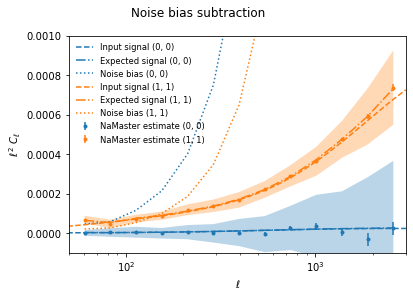

In [11]:
def make_noise_subtraction_plot(wsp, randoms, title, filename):
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust(right=0.98, left=0.2)

    ell_eff = BIN_OPERATOR @ ell[:n_ell]

    for i, idx in enumerate([(0,0), (1,1)]):
        u = ell**2
        ax.plot(ell, u*Cl_EE_signal[idx], c=f"C{i}", ls="--", label=f"Input signal {idx}")

        if idx in wsp:
            u = ell_eff**2
            Cl_theory = wsp[idx].decouple_cell(wsp[idx].couple_cell([Cl_EE_signal[idx], Cl_0, Cl_0, Cl_0]))[0]
            ax.plot(ell_eff, u*Cl_theory, c=f"C{i}", ls="-.", label=f"Expected signal {idx}")

            Cl_EE_noise = wsp[idx].decouple_cell([Cl_N[idx], Cl_0, Cl_0, Cl_N[idx]])[0]
            ax.plot(ell_eff, u*Cl_EE_noise, c=f"C{i}", ls=":", label=f"Noise bias {idx}")

        if idx in randoms:
            u = ell_eff**2
            Cl = randoms[idx].mean(axis=0)
            std_err = np.sqrt(randoms[idx].var(axis=0, ddof=1)/randoms[idx].shape[0])
            err = np.sqrt(randoms[idx].var(axis=0, ddof=1))
            ax.fill_between(ell_eff, u*(Cl-err), u*(Cl+err), facecolor=f"C{i}", alpha=0.3)
            ax.errorbar(ell_eff, u*Cl, u*std_err, ls="none", marker=".", c=f"C{i}", label=f"NaMaster estimate {idx}")

            def snr_from_samples(samples, **kwargs):
                r = Cl_theory[1:-2]
                Psi = np.linalg.inv(np.cov(samples.T, ddof=1))
                return np.sqrt(r @ Psi @ r)
            
            snr = snr_from_samples(randoms[idx][:,1:-2])
            snr_var = bootstrap_var(randoms[idx][:,1:-2], n=100,
                                    func=snr_from_samples)
            print(f"SNR for {idx}: {snr:.1f}±{np.sqrt(snr_var):.1f}")

    ax.set_xscale("log")
    ax.set_xlim(50, 3000)
    ax.set_ylim(bottom=-1e-4, top=1e-3)

    ax.legend(fontsize="small", frameon=False)
    ax.set_xlabel(r"$\ell$")
    ax.set_ylabel(r"$\ell^2\ C_\ell$")

    fig.suptitle(title)
    fig.savefig(filename, facecolor="w", dpi=300)


make_noise_subtraction_plot(wsp=nmt_workspace,
                            randoms=true_random_shear_with_signal_no_noise_bias_EE,
                            title="Noise bias subtraction",
                            filename="plots/noise_bias_subtraction.png")

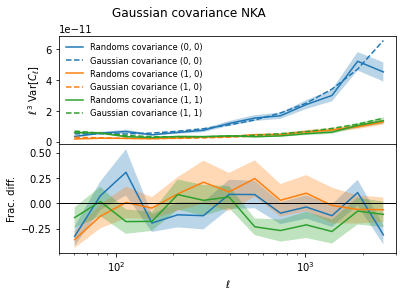

In [19]:
cov_shear_shear_NKA_EE = {(0,0): np.load("../results/measurements/shear_KiDS1000_shear_KiDS1000/cov/cov_shear_shear_0-0_0-0.npz")["ssss"],
                          (1,0): np.load("../results/measurements/shear_KiDS1000_shear_KiDS1000/cov/cov_shear_shear_4-0_4-0.npz")["ssss"],
                          (1,1): np.load("../results/measurements/shear_KiDS1000_shear_KiDS1000/cov/cov_shear_shear_4-4_4-4.npz")["ssss"]}
cov_shear_shear_NKA_EE = {n: c.reshape(n_ell_bin, 4, n_ell_bin,4)[:,0,:,0] for n, c in cov_shear_shear_NKA_EE.items()}

def make_covariance_plot(randoms, covariance, title, filename, indicies):
    fig, ax = plt.subplots(2, 1, sharex=True)
    fig.subplots_adjust(right=0.98, left=0.2, hspace=0)

    ell_eff = BIN_OPERATOR @ ell[:n_ell]

    for i, idx in enumerate(indicies):
        u = ell_eff**3

        var = randoms[idx].var(axis=0, ddof=1)
        var_err = np.sqrt(bootstrap_var(randoms[idx], n=100))
        ax[0].fill_between(ell_eff, u*(var-var_err), u*(var+var_err), facecolor=f"C{i}", alpha=0.3)
        ax[0].plot(ell_eff, u*var, c=f"C{i}", ls="-", label=f"Randoms covariance {idx}")

        var_gaussian = np.diag(covariance[idx])
        ax[0].plot(ell_eff, u*var_gaussian, c=f"C{i}", ls="--", label=f"Gaussian covariance {idx}")

        ax[1].fill_between(ell_eff, (var-var_err)/var_gaussian-1, (var+var_err)/var_gaussian-1, facecolor=f"C{i}", alpha=0.3)
        ax[1].plot(ell_eff, var/var_gaussian-1, c=f"C{i}", ls="-")

    ax[1].axhline(0, c="k", lw=1)

    ax[0].set_xscale("log")
    ax[0].set_xlim(50, 3000)
    # ax.set_ylim(bottom=-1e-4, top=1e-3)

    ax[0].legend(fontsize="small", frameon=False)
    ax[1].set_xlabel(r"$\ell$")
    ax[0].set_ylabel(r"$\ell^3\ \mathrm{Var}[C_\ell]$")
    ax[1].set_ylabel(r"Frac. diff.")

    fig.suptitle(title)
    fig.savefig(filename, facecolor="w", dpi=300)


make_covariance_plot(randoms=true_random_shear_with_signal_no_noise_bias_EE,
                     covariance=cov_shear_shear_NKA_EE,
                     title="Gaussian covariance NKA",
                     filename="plots/gaussian_nka_cov.png",
                     indicies=[(0,0), (1,0), (1,1)])

In [29]:
nmt_workspace_binary_mask = {}
nmt_workspace_binary_mask[(0,0)] = nmt.NmtWorkspace()
nmt_workspace_binary_mask[(0,0)].read_from(os.path.join(NMT_WORKSPACE_PATH, "shear_KiDS1000_shear_KiDS1000_binary_mask/pymaster_workspace_shear_0_shear_0.fits"))
nmt_workspace_binary_mask[(1,1)] = nmt.NmtWorkspace()
nmt_workspace_binary_mask[(1,1)].read_from(os.path.join(NMT_WORKSPACE_PATH, "shear_KiDS1000_shear_KiDS1000_binary_mask/pymaster_workspace_shear_4_shear_4.fits"))


In [30]:
true_random_shear_with_signal_no_noise_bias_binary_mask_EE = {
    (0,0): np.load("../results/measurements/shear_KiDS1000_true_randoms_with_signal_binary_mask/run_0/Cl_decoupled_no_noise_bias_z0.1-0.3_gal.npz")["EE"][:],
    (1,1): np.load("../results/measurements/shear_KiDS1000_true_randoms_with_signal_binary_mask/run_0/Cl_decoupled_no_noise_bias_z0.9-1.2_gal.npz")["EE"][:]}

true_random_shear_with_signal_coupled_binary_mask_EE = {
    (0,0): np.load("../results/measurements/shear_KiDS1000_true_randoms_with_signal_binary_mask/run_0/Cl_coupled_z0.1-0.3_gal.npz")["EE"][:],
    (1,1): np.load("../results/measurements/shear_KiDS1000_true_randoms_with_signal_binary_mask/run_0/Cl_coupled_z0.9-1.2_gal.npz")["EE"][:]}

SNR for (0, 0): 0.6±0.1
SNR for (1, 1): 14.6±1.2


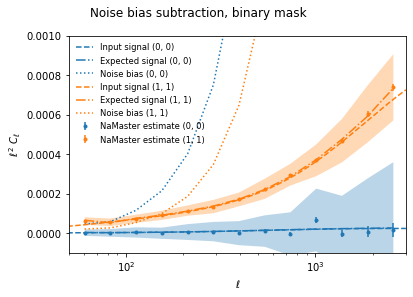

In [40]:
make_noise_subtraction_plot(wsp=nmt_workspace_binary_mask,
                            randoms=true_random_shear_with_signal_no_noise_bias_binary_mask_EE,
                            title="Noise bias subtraction, binary mask",
                            filename="plots/noise_bias_subtraction_binary_mask.png")

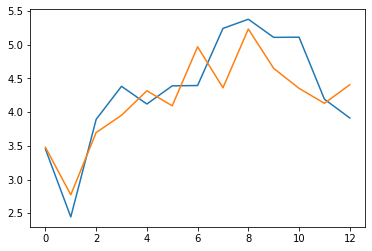

In [35]:
plt.plot(nmt_workspace[(1,1)].decouple_cell(nmt_workspace[(1,1)].couple_cell([Cl_EE_signal[(1,1)], Cl_0, Cl_0, Cl_0]))[0]/np.std(true_random_shear_with_signal_no_noise_bias_EE[(1,1)], axis=0))
plt.plot(nmt_workspace_binary_mask[(1,1)].decouple_cell(nmt_workspace_binary_mask[(1,1)].couple_cell([Cl_EE_signal[(1,1)], Cl_0, Cl_0, Cl_0]))[0]/np.std(true_random_shear_with_signal_no_noise_bias_binary_mask_EE[(1,1)], axis=0))

In [36]:
ell_eff

array([  60.49586777,   82.63030303,  112.90666667,  154.74621212,
        211.67220903,  289.29565217,  395.10828025,  539.78404851,
        737.86211604, 1009.04792811, 1379.44320672, 1884.93540052,
       2575.95067162])

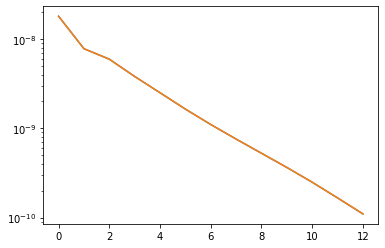

In [32]:
plt.semilogy(nmt_workspace[(1,1)].decouple_cell(nmt_workspace[(1,1)].couple_cell([Cl_EE_signal[(1,1)], Cl_0, Cl_0, Cl_0]))[0])
plt.semilogy(nmt_workspace_binary_mask[(1,1)].decouple_cell(nmt_workspace_binary_mask[(1,1)].couple_cell([Cl_EE_signal[(1,1)], Cl_0, Cl_0, Cl_0]))[0])

## Assemble covariance

In [8]:
field_idx = [(i, j) for i in range(5)
              for j in range(i+1)]

full_cov_gaussian_EE = np.zeros((n_ell_bin*len(field_idx), n_ell_bin*len(field_idx)))

for i, (idx_a1, idx_a2) in enumerate(field_idx):
    for j, (idx_b1, idx_b2) in enumerate(field_idx[:i+1]):
        c = np.load(f"../results/measurements/shear_KiDS1000_shear_KiDS1000/cov/cov_shear_shear_{idx_a1}-{idx_a2}_{idx_b1}-{idx_b2}.npz")["ssss"].reshape(n_ell_bin, 4, n_ell_bin, 4)[:,0,:,0]

        full_cov_gaussian_EE[i*n_ell_bin:(i+1)*n_ell_bin, j*n_ell_bin:(j+1)*n_ell_bin] = c

In [1]:
full_cov_gaussian_EE[np.triu_indices_from(full_cov_gaussian_EE, k=1)] = full_cov_gaussian_EE.T[np.triu_indices_from(full_cov_gaussian_EE, k=1)]

NameError: name 'full_cov_gaussian_EE' is not defined

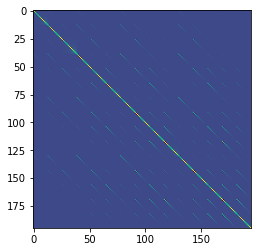

In [12]:
s = np.diag(1/np.sqrt(np.diag(full_cov_gaussian_EE)))
plt.imshow(s@full_cov_gaussian_EE@s)

In [13]:
np.diag(s@full_cov_gaussian_EE@s)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [21]:
# w_sq = healpy.read_map(f"../data/shear_maps_KiDS1000/z0.1-0.3/w_sq.fits", verbose=False)
w = healpy.read_map(f"../data/shear_maps_KiDS1000_cel/z0.1-0.3/doublet_weight.fits", verbose=False)
w_sq_e_sq = healpy.read_map(f"../data/shear_maps_KiDS1000_cel/z0.1-0.3/w_sq_e_sq.fits", verbose=False)

# w_sq[w_sq == healpy.UNSEEN] = 0
w[w == healpy.UNSEEN] = 0
w_sq_e_sq[w_sq_e_sq == healpy.UNSEEN] = 0

w_IV = w**2/w_sq_e_sq
w_IV[w == 0] = 0

/home/ttroester/Codes/miniconda/envs/kcap_env_re/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
<ipython-input-21-6a7739f7cbba>:9: RuntimeWarning: invalid value encountered in true_divide
  w_IV = w**2/w_sq_e_sq


In [22]:
Cl_mask = healpy.anafast(w, pol=False)
Cl_mask_IV = healpy.anafast(w_IV, pol=False)

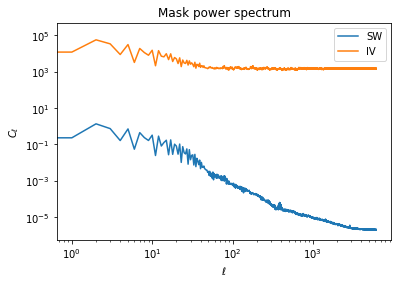

In [23]:
ell = np.arange(Cl_mask.size)
plt.loglog(ell, Cl_mask, label="SW")
plt.loglog(ell, Cl_mask_IV, label="IV")

plt.legend()

plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Mask power spectrum")
plt.savefig("plots/weights_power_spectrum.png")

# y-y

In [2]:
nside = 2048

binning_operator = np.loadtxt("../data/xcorr/bin_operator_log_n_bin_12_ell_51-2952_namaster.txt")
ell = np.arange(binning_operator.size)

nmt_bins = nmt.NmtBin(nside=nside, bpws=binning_operator, ells=ell, weights=2*ell+1)

In [3]:
y_map = healpy.read_map("../data/y_maps/polspice/milca/triplet.fits")
y_mask = healpy.read_map("../data/y_maps/polspice/milca/singlet_mask.fits")

y_map[y_map == healpy.UNSEEN] = 0
y_mask[y_mask == healpy.UNSEEN] = 0

field_y = nmt.NmtField(y_mask, [y_map], spin=0)

/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [4]:
mean_w2 = (y_mask**2).mean()

wsp = nmt.NmtWorkspace()
wsp.compute_coupling_matrix(field_y, field_y, nmt_bins)

Cl_y_y_coupled = nmt.compute_coupled_cell(field_y, field_y)
Cl_y_y_decoupled = wsp.decouple_cell(Cl_y_y_coupled)

In [5]:
Cl_y_y_decoupled

array([[1.37778386e-16, 9.76780696e-17, 8.41480803e-17, 6.07107159e-17,
        4.68665979e-17, 3.71540566e-17, 2.76476462e-17, 1.91761990e-17,
        1.10401929e-17, 4.46379665e-18, 9.69882936e-19, 8.51455938e-20]])

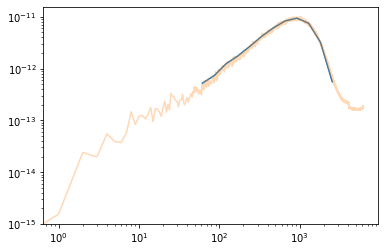

In [12]:
import scipy.interpolate

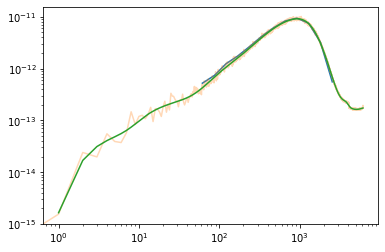

In [15]:
intp = scipy.interpolate.UnivariateSpline(np.log(ell[1:]), np.log(Cl_y_y_coupled[0][1:]/mean_w2), s=10)

ell_bin = nmt_bins.get_effective_ells()
ell = np.arange(3*nside)

plt.loglog(ell_bin, ell_bin**2*Cl_y_y_decoupled[0])
plt.loglog(ell, ell**2*Cl_y_y_coupled[0]/mean_w2, alpha=0.3)
plt.loglog(ell[1:], ell[1:]**2*np.exp(intp(np.log(ell[1:]))), alpha=1.0)

In [19]:
Cl_cov = Cl_y_y_coupled[0]/mean_w2
Cl_noise_cov = np.zeros_like(Cl_cov)

np.savez("../results/measurements/y_milca_y_milca/cov_Cls/Cl_cov_raw_0-0.npz",
         ell=ell,
         Cl_cov=[Cl_cov], Cl_noise_cov=[Cl_noise_cov])

Cl_cov[1:] = np.exp(intp(np.log(ell[1:])))
np.savez("../results/measurements/y_milca_y_milca/cov_Cls/Cl_cov_smoothed_0-0.npz",
         ell=ell,
         Cl_cov=[Cl_cov], Cl_noise_cov=[Cl_noise_cov])

# Sigma2_B stuff

In [8]:
import scipy.special

In [30]:
shear_mask = healpy.read_map("../data/shear_maps_KiDS1000/z0.1-1.2/n_gal.fits") > 0

planck_mask = healpy.read_map("../data/y_maps/Planck_processed/mask_ps_gal40.fits") > 0

/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/ttroester/Codes/miniconda/envs/analysis/lib/python3.9/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = EXPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/home/ttroester/Codes/miniconda/envs/analysis/lib/p

In [31]:
ell = np.arange(3*2048)

# m = np.zeros(healpy.nside2npix(2048))
# m[:int(len(m)*0.02)] = 1
W_shear_shear_l = healpy.anafast(shear_mask, shear_mask)
A_shear = shear_mask.sum()*healpy.nside2pixarea(2048)

W_shear_shear_l = W_shear_shear_l * (2*ell + 1)/ A_shear**2

W_shear_planck_l = healpy.anafast(shear_mask, planck_mask)
A_planck = planck_mask.sum()*healpy.nside2pixarea(2048)

W_shear_planck_l = W_shear_planck_l * (2*ell + 1)/ (A_shear*A_planck)


In [39]:
W_shear_planck_prod_l = healpy.anafast(shear_mask*planck_mask)
A_shear_planck = (shear_mask*planck_mask).sum()*healpy.nside2pixarea(2048)

W_shear_planck_prod_l = W_shear_planck_prod_l * (2*ell + 1)/ A_shear_planck**2


In [32]:
P_1l = lambda l, x: scipy.special.lpmv(1, l, x)
pi = np.pi

fsky = A_shear/(4*pi)
theta = np.arccos(1-2*fsky)

fsky_W_Cl = pi*(2*ell+1)/(ell**2 * (ell+1)**2) * np.sin(theta)**2 * P_1l(ell, np.cos(theta))**2 / A_shear**2

<ipython-input-32-7b6169832ede>:7: RuntimeWarning: divide by zero encountered in true_divide
  fsky_W_Cl = pi*(2*ell+1)/(ell**2 * (ell+1)**2) * np.sin(theta)**2 * P_1l(ell, np.cos(theta))**2 / A_shear**2
<ipython-input-32-7b6169832ede>:7: RuntimeWarning: invalid value encountered in multiply
  fsky_W_Cl = pi*(2*ell+1)/(ell**2 * (ell+1)**2) * np.sin(theta)**2 * P_1l(ell, np.cos(theta))**2 / A_shear**2


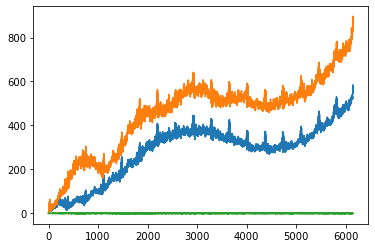

In [40]:
u = ell**2
plt.plot(ell, u*W_shear_shear_l)
# plt.plot(ell, u*fsky_W_Cl)

plt.plot(ell, u*W_shear_planck_prod_l)
plt.plot(ell, u*W_shear_planck_l)


# plt.xlim(0, 100)

In [42]:
np.savetxt("../data/xcorr/cov/W_l/shear_KiDS1000_binary_auto.txt", 
           np.vstack((ell, W_shear_shear_l)).T,
           header=f"A_shear = {A_shear} sr")
np.savetxt("../data/xcorr/cov/W_l/shear_KiDS1000_Planck_binary.txt", 
           np.vstack((ell, W_shear_planck_l)).T,
           header=f"A_shear = {A_shear} sr, A_Planck = {A_planck}")
np.savetxt("../data/xcorr/cov/W_l/shear_KiDS1000_Planck_overlap_binary.txt", 
           np.vstack((ell, W_shear_planck_prod_l)).T,
           header=f"A_shear_Planck = {A_shear_planck} sr")

(6144,)

In [3]:
d = np.load("../results/measurements/shear_KiDS1000_y_milca/cov_Cls/Cl_cov_CCL_gal_0-0.npz")

In [11]:
ell = np.arange(6144)
Cl_0 = np.zeros((2, ell.size))

for i in range(5):
    np.savez(f"../results/measurements/shear_KiDS1000_545GHz_CIB/cov_Cls/Cl_cov_zeros_{i}-0.npz",
             ell=ell, Cl_cov=Cl_0, Cl_noise_cov=Cl_0)

In [7]:
list(d.keys())

['ell', 'Cl_cov', 'Cl_noise_cov']